# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

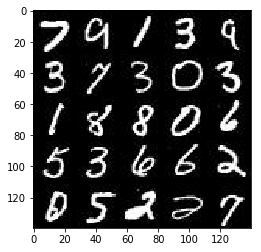

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

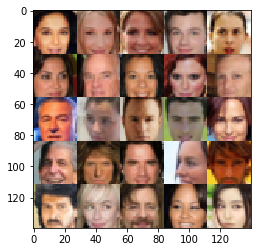

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    # it must be float32, cannot be int32
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels))
    input_z = tf.placeholder(tf.float32, (None, z_dim))
    learn_rate = tf.placeholder(tf.float32, [])

    return input_real, input_z, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # shape of images = [None, 28, 28, 3]
        conv_layer1 = tf.layers.conv2d(images, 64, (5,5), strides=(2,2), padding='same', activation=tf.nn.relu)
        conv_layer2 = tf.layers.conv2d(conv_layer1, 128, (7,7), strides=(2,2), padding='same', activation=tf.nn.relu)
        conv_layer3 = tf.layers.conv2d(conv_layer2, 256, (3,3), strides=(2,2), padding='same', activation=tf.nn.relu)
        
        flatten_layer = tf.contrib.layers.flatten(conv_layer3)
        
        logits = tf.layers.dense(flatten_layer, 1)
        out = tf.sigmoid(logits)

    # shape of out should be shape=(?, 28, 28, 3)
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    reuse = not is_train
    
    # out_channel_dim = 5 in this test case
    
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer, shape 28 * 28 * 2
        fully_connected_layer = tf.layers.dense(z, 1568 * 8, activation=tf.nn.relu)
        # print(fully_connected_layer.shape)
        # 1568 now

        # Reshape it to start the convolutional stack
        x1 = tf.reshape(fully_connected_layer, (-1, 7, 7, 256))
        # print(x1.shape)
        # 7*7*64 now
        
        x2 = tf.layers.conv2d_transpose(x1, 128, (5, 5), strides=(2, 2), padding='same', activation=tf.nn.relu)
        # print(x2.shape)
        # 14*14 now
        
        x3 = tf.layers.conv2d_transpose(x2, 64, (5, 5), strides=(2, 2), padding='same', activation=tf.nn.relu)
        # print(x3.shape)
        # 28*28*16 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, (3, 3), strides=(1,1), padding='same')
        # print(logits.shape)
        # 28*28*5 now
        
        out = tf.tanh(logits)
    
    # 28 x 28 x out_channel_dim images = 28 * 28 * 5
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    # Copied from DCGAN.ipynb
    
    # signature: generator(z, out_channel_dim, is_train=True)
    g_model = generator(input_z, out_channel_dim)
    
    # signature: discriminator(images, reuse=False)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Copied from DCGAN.ipynb
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    # I have no idea why I got no variable saved error
    # saver = tf.train.Saver()

    steps = 0
    
    losses = []
    
    _, image_width, image_height, image_channels = data_shape
    
    # signature: model_inputs(image_width, image_height, image_channels, z_dim)
    # return: input_real, input_z, learn_rate
    input_real, input_z, learn_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    
    # signature: model_loss(input_real, input_z, out_channel_dim)
    # return: d_loss, g_loss
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    
    # signature: model_opt(d_loss, g_loss, learning_rate, beta1)
    # return: d_train_opt, g_train_opt
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_idx, batch_images in enumerate(get_batches(batch_size)):
                # TODO: Train Model
                
                steps += 1
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(50, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, 
                                                     input_z: batch_z, 
                                                     learn_rate:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, 
                                                     learn_rate:learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Batch {}...".format(batch_idx+1),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps % 100 == 0:
                    # Signature: show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode)
                    show_generator_output(sess, 4, input_z, image_channels, data_image_mode)
    
        # saver.save(sess, './checkpoints/generator.ckpt')

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Batch 10... Discriminator Loss: 1.0883... Generator Loss: 0.6753
Epoch 1/2... Batch 20... Discriminator Loss: 0.9035... Generator Loss: 0.5998
Epoch 1/2... Batch 30... Discriminator Loss: 0.8750... Generator Loss: 0.6077
Epoch 1/2... Batch 40... Discriminator Loss: 0.9711... Generator Loss: 0.6006
Epoch 1/2... Batch 50... Discriminator Loss: 1.0292... Generator Loss: 0.5649
Epoch 1/2... Batch 60... Discriminator Loss: 0.9109... Generator Loss: 1.3658
Epoch 1/2... Batch 70... Discriminator Loss: 1.0231... Generator Loss: 0.7059
Epoch 1/2... Batch 80... Discriminator Loss: 0.7934... Generator Loss: 1.0857
Epoch 1/2... Batch 90... Discriminator Loss: 0.9611... Generator Loss: 0.7575
Epoch 1/2... Batch 100... Discriminator Loss: 0.9794... Generator Loss: 0.8158


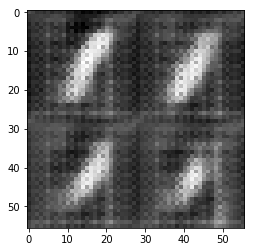

Epoch 1/2... Batch 110... Discriminator Loss: 1.2003... Generator Loss: 0.7634
Epoch 1/2... Batch 120... Discriminator Loss: 1.2045... Generator Loss: 0.8796
Epoch 1/2... Batch 130... Discriminator Loss: 1.2368... Generator Loss: 0.7016
Epoch 1/2... Batch 140... Discriminator Loss: 1.1928... Generator Loss: 0.8844
Epoch 1/2... Batch 150... Discriminator Loss: 1.1120... Generator Loss: 0.9290
Epoch 1/2... Batch 160... Discriminator Loss: 1.0517... Generator Loss: 1.1740
Epoch 1/2... Batch 170... Discriminator Loss: 1.1568... Generator Loss: 0.8948
Epoch 1/2... Batch 180... Discriminator Loss: 1.0220... Generator Loss: 0.9662
Epoch 1/2... Batch 190... Discriminator Loss: 1.1504... Generator Loss: 0.8361
Epoch 1/2... Batch 200... Discriminator Loss: 1.1252... Generator Loss: 0.8374


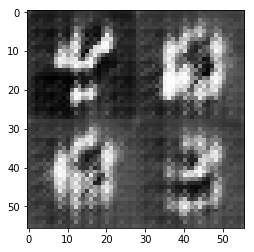

Epoch 1/2... Batch 210... Discriminator Loss: 1.1528... Generator Loss: 1.1047
Epoch 1/2... Batch 220... Discriminator Loss: 1.0168... Generator Loss: 1.1031
Epoch 1/2... Batch 230... Discriminator Loss: 1.2219... Generator Loss: 0.7929
Epoch 1/2... Batch 240... Discriminator Loss: 1.1155... Generator Loss: 1.0993
Epoch 1/2... Batch 250... Discriminator Loss: 1.2795... Generator Loss: 0.6689
Epoch 1/2... Batch 260... Discriminator Loss: 1.0290... Generator Loss: 0.7713
Epoch 1/2... Batch 270... Discriminator Loss: 1.2976... Generator Loss: 0.5695
Epoch 1/2... Batch 280... Discriminator Loss: 1.0734... Generator Loss: 0.9270
Epoch 1/2... Batch 290... Discriminator Loss: 1.0902... Generator Loss: 1.1447
Epoch 1/2... Batch 300... Discriminator Loss: 1.1893... Generator Loss: 0.6454


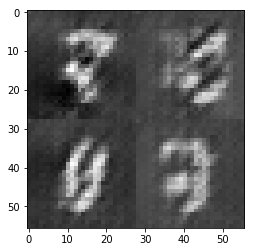

Epoch 1/2... Batch 310... Discriminator Loss: 1.1783... Generator Loss: 0.6437
Epoch 1/2... Batch 320... Discriminator Loss: 1.0614... Generator Loss: 0.6868
Epoch 1/2... Batch 330... Discriminator Loss: 1.3884... Generator Loss: 1.1785
Epoch 1/2... Batch 340... Discriminator Loss: 1.0860... Generator Loss: 0.9377
Epoch 1/2... Batch 350... Discriminator Loss: 1.0272... Generator Loss: 0.9715
Epoch 1/2... Batch 360... Discriminator Loss: 1.1432... Generator Loss: 1.1170
Epoch 1/2... Batch 370... Discriminator Loss: 1.0952... Generator Loss: 1.0866
Epoch 1/2... Batch 380... Discriminator Loss: 1.1285... Generator Loss: 0.9962
Epoch 1/2... Batch 390... Discriminator Loss: 1.1136... Generator Loss: 0.8527
Epoch 1/2... Batch 400... Discriminator Loss: 1.2235... Generator Loss: 0.6190


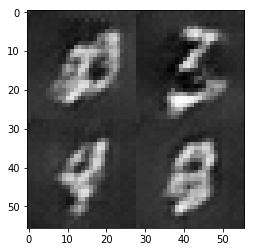

Epoch 1/2... Batch 410... Discriminator Loss: 1.2100... Generator Loss: 0.8131
Epoch 1/2... Batch 420... Discriminator Loss: 1.1676... Generator Loss: 0.5483
Epoch 1/2... Batch 430... Discriminator Loss: 1.2508... Generator Loss: 0.5679
Epoch 1/2... Batch 440... Discriminator Loss: 1.2047... Generator Loss: 1.1448
Epoch 1/2... Batch 450... Discriminator Loss: 1.5478... Generator Loss: 0.3238
Epoch 1/2... Batch 460... Discriminator Loss: 1.2516... Generator Loss: 0.8755
Epoch 1/2... Batch 470... Discriminator Loss: 1.2583... Generator Loss: 0.4650
Epoch 1/2... Batch 480... Discriminator Loss: 1.0576... Generator Loss: 1.0968
Epoch 1/2... Batch 490... Discriminator Loss: 1.0473... Generator Loss: 1.2081
Epoch 1/2... Batch 500... Discriminator Loss: 1.0696... Generator Loss: 0.7227


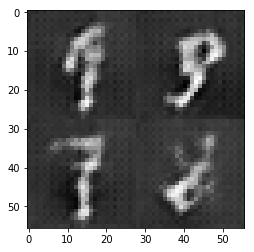

Epoch 1/2... Batch 510... Discriminator Loss: 0.9768... Generator Loss: 1.0966
Epoch 1/2... Batch 520... Discriminator Loss: 1.0866... Generator Loss: 0.7924
Epoch 1/2... Batch 530... Discriminator Loss: 1.1775... Generator Loss: 0.5695
Epoch 1/2... Batch 540... Discriminator Loss: 1.3229... Generator Loss: 0.4232
Epoch 1/2... Batch 550... Discriminator Loss: 1.0991... Generator Loss: 0.8717
Epoch 1/2... Batch 560... Discriminator Loss: 1.0971... Generator Loss: 0.9463
Epoch 1/2... Batch 570... Discriminator Loss: 1.1394... Generator Loss: 0.7588
Epoch 1/2... Batch 580... Discriminator Loss: 1.2529... Generator Loss: 0.4674
Epoch 1/2... Batch 590... Discriminator Loss: 1.1052... Generator Loss: 0.6633
Epoch 1/2... Batch 600... Discriminator Loss: 1.2208... Generator Loss: 1.0230


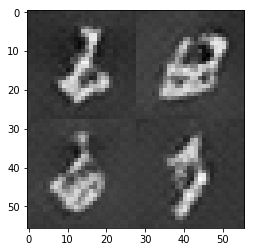

Epoch 1/2... Batch 610... Discriminator Loss: 0.9777... Generator Loss: 1.1863
Epoch 1/2... Batch 620... Discriminator Loss: 1.1467... Generator Loss: 0.7856
Epoch 1/2... Batch 630... Discriminator Loss: 1.1577... Generator Loss: 0.7316
Epoch 1/2... Batch 640... Discriminator Loss: 1.1316... Generator Loss: 1.2011
Epoch 1/2... Batch 650... Discriminator Loss: 1.3247... Generator Loss: 0.9488
Epoch 1/2... Batch 660... Discriminator Loss: 0.9831... Generator Loss: 1.0761
Epoch 1/2... Batch 670... Discriminator Loss: 1.2034... Generator Loss: 0.5576
Epoch 1/2... Batch 680... Discriminator Loss: 1.0798... Generator Loss: 0.9204
Epoch 1/2... Batch 690... Discriminator Loss: 1.1505... Generator Loss: 1.0278
Epoch 1/2... Batch 700... Discriminator Loss: 1.1568... Generator Loss: 1.0931


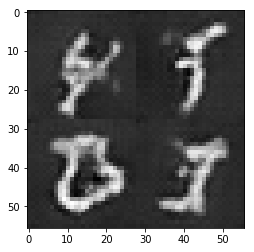

Epoch 1/2... Batch 710... Discriminator Loss: 1.3122... Generator Loss: 0.4703
Epoch 1/2... Batch 720... Discriminator Loss: 1.1286... Generator Loss: 0.6036
Epoch 1/2... Batch 730... Discriminator Loss: 1.0939... Generator Loss: 1.0560
Epoch 1/2... Batch 740... Discriminator Loss: 1.1309... Generator Loss: 1.0316
Epoch 1/2... Batch 750... Discriminator Loss: 1.1686... Generator Loss: 0.5827
Epoch 1/2... Batch 760... Discriminator Loss: 1.1658... Generator Loss: 0.6858
Epoch 1/2... Batch 770... Discriminator Loss: 1.1931... Generator Loss: 1.1343
Epoch 1/2... Batch 780... Discriminator Loss: 1.1919... Generator Loss: 0.9409
Epoch 1/2... Batch 790... Discriminator Loss: 1.1785... Generator Loss: 0.8233
Epoch 1/2... Batch 800... Discriminator Loss: 1.2899... Generator Loss: 0.8824


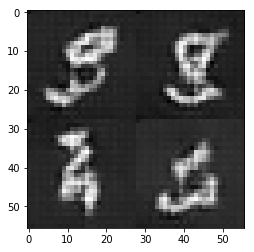

Epoch 1/2... Batch 810... Discriminator Loss: 1.3092... Generator Loss: 0.4249
Epoch 1/2... Batch 820... Discriminator Loss: 1.1555... Generator Loss: 0.7720
Epoch 1/2... Batch 830... Discriminator Loss: 1.2567... Generator Loss: 0.8037
Epoch 1/2... Batch 840... Discriminator Loss: 1.1650... Generator Loss: 0.6867
Epoch 1/2... Batch 850... Discriminator Loss: 1.0766... Generator Loss: 0.8466
Epoch 1/2... Batch 860... Discriminator Loss: 1.4683... Generator Loss: 0.3718
Epoch 1/2... Batch 870... Discriminator Loss: 1.1264... Generator Loss: 1.1389
Epoch 1/2... Batch 880... Discriminator Loss: 1.2795... Generator Loss: 1.2101
Epoch 1/2... Batch 890... Discriminator Loss: 1.1471... Generator Loss: 0.8811
Epoch 1/2... Batch 900... Discriminator Loss: 1.2282... Generator Loss: 0.5554


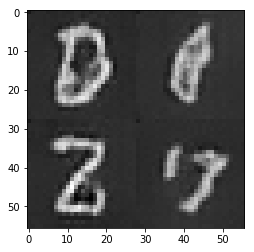

Epoch 1/2... Batch 910... Discriminator Loss: 1.2025... Generator Loss: 1.1101
Epoch 1/2... Batch 920... Discriminator Loss: 1.1885... Generator Loss: 1.0334
Epoch 1/2... Batch 930... Discriminator Loss: 1.2814... Generator Loss: 1.3330
Epoch 1/2... Batch 940... Discriminator Loss: 1.2129... Generator Loss: 0.8065
Epoch 1/2... Batch 950... Discriminator Loss: 1.1982... Generator Loss: 0.7473
Epoch 1/2... Batch 960... Discriminator Loss: 1.1189... Generator Loss: 0.7994
Epoch 1/2... Batch 970... Discriminator Loss: 1.1605... Generator Loss: 0.7353
Epoch 1/2... Batch 980... Discriminator Loss: 1.1415... Generator Loss: 0.9271
Epoch 1/2... Batch 990... Discriminator Loss: 1.2094... Generator Loss: 1.1455
Epoch 1/2... Batch 1000... Discriminator Loss: 1.1920... Generator Loss: 0.9906


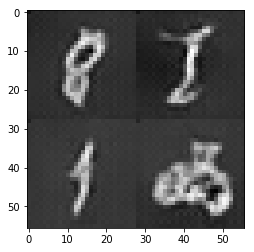

Epoch 1/2... Batch 1010... Discriminator Loss: 1.1327... Generator Loss: 1.0045
Epoch 1/2... Batch 1020... Discriminator Loss: 1.1460... Generator Loss: 0.9241
Epoch 1/2... Batch 1030... Discriminator Loss: 1.1376... Generator Loss: 0.7608
Epoch 1/2... Batch 1040... Discriminator Loss: 1.1069... Generator Loss: 0.9242
Epoch 1/2... Batch 1050... Discriminator Loss: 1.2814... Generator Loss: 0.5667
Epoch 1/2... Batch 1060... Discriminator Loss: 1.1268... Generator Loss: 0.9464
Epoch 1/2... Batch 1070... Discriminator Loss: 1.1463... Generator Loss: 0.8414
Epoch 1/2... Batch 1080... Discriminator Loss: 1.2866... Generator Loss: 1.1491
Epoch 1/2... Batch 1090... Discriminator Loss: 1.3225... Generator Loss: 0.4476
Epoch 1/2... Batch 1100... Discriminator Loss: 1.4259... Generator Loss: 0.3978


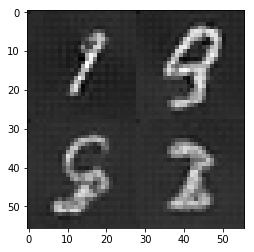

Epoch 1/2... Batch 1110... Discriminator Loss: 1.3602... Generator Loss: 0.8497
Epoch 1/2... Batch 1120... Discriminator Loss: 1.3570... Generator Loss: 0.7380
Epoch 1/2... Batch 1130... Discriminator Loss: 1.2863... Generator Loss: 0.6806
Epoch 1/2... Batch 1140... Discriminator Loss: 1.1466... Generator Loss: 0.9439
Epoch 1/2... Batch 1150... Discriminator Loss: 1.2138... Generator Loss: 1.0155
Epoch 1/2... Batch 1160... Discriminator Loss: 1.1140... Generator Loss: 0.8204
Epoch 1/2... Batch 1170... Discriminator Loss: 1.2666... Generator Loss: 1.1208
Epoch 1/2... Batch 1180... Discriminator Loss: 1.2548... Generator Loss: 1.2727
Epoch 1/2... Batch 1190... Discriminator Loss: 1.2226... Generator Loss: 0.8572
Epoch 1/2... Batch 1200... Discriminator Loss: 1.1421... Generator Loss: 1.0715


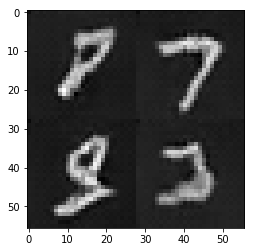

Epoch 1/2... Batch 1210... Discriminator Loss: 1.1602... Generator Loss: 1.0049
Epoch 1/2... Batch 1220... Discriminator Loss: 1.1764... Generator Loss: 0.8593
Epoch 1/2... Batch 1230... Discriminator Loss: 1.2698... Generator Loss: 0.7729
Epoch 1/2... Batch 1240... Discriminator Loss: 1.1613... Generator Loss: 0.7010
Epoch 1/2... Batch 1250... Discriminator Loss: 1.4767... Generator Loss: 0.3456
Epoch 1/2... Batch 1260... Discriminator Loss: 1.1989... Generator Loss: 0.6269
Epoch 1/2... Batch 1270... Discriminator Loss: 1.1533... Generator Loss: 0.8779
Epoch 1/2... Batch 1280... Discriminator Loss: 1.0964... Generator Loss: 0.9505
Epoch 1/2... Batch 1290... Discriminator Loss: 1.3573... Generator Loss: 0.4744
Epoch 1/2... Batch 1300... Discriminator Loss: 1.2192... Generator Loss: 1.2516


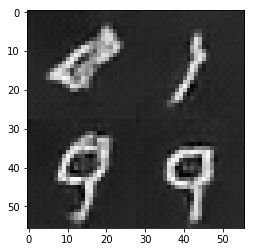

Epoch 1/2... Batch 1310... Discriminator Loss: 1.1773... Generator Loss: 0.6537
Epoch 1/2... Batch 1320... Discriminator Loss: 1.1442... Generator Loss: 1.2034
Epoch 1/2... Batch 1330... Discriminator Loss: 1.1419... Generator Loss: 0.8321
Epoch 1/2... Batch 1340... Discriminator Loss: 1.1447... Generator Loss: 0.6986
Epoch 1/2... Batch 1350... Discriminator Loss: 1.1379... Generator Loss: 0.9991
Epoch 1/2... Batch 1360... Discriminator Loss: 1.2071... Generator Loss: 0.6678
Epoch 1/2... Batch 1370... Discriminator Loss: 1.2559... Generator Loss: 0.5937
Epoch 1/2... Batch 1380... Discriminator Loss: 1.0863... Generator Loss: 0.9225
Epoch 1/2... Batch 1390... Discriminator Loss: 1.2139... Generator Loss: 0.6821
Epoch 1/2... Batch 1400... Discriminator Loss: 1.3455... Generator Loss: 1.0769


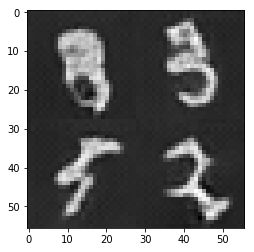

Epoch 1/2... Batch 1410... Discriminator Loss: 1.1330... Generator Loss: 1.0413
Epoch 1/2... Batch 1420... Discriminator Loss: 1.2372... Generator Loss: 0.6105
Epoch 1/2... Batch 1430... Discriminator Loss: 1.2023... Generator Loss: 1.0978
Epoch 1/2... Batch 1440... Discriminator Loss: 1.1806... Generator Loss: 0.7337
Epoch 1/2... Batch 1450... Discriminator Loss: 1.1165... Generator Loss: 0.8808
Epoch 1/2... Batch 1460... Discriminator Loss: 1.2174... Generator Loss: 1.2781
Epoch 1/2... Batch 1470... Discriminator Loss: 1.1960... Generator Loss: 0.8429
Epoch 1/2... Batch 1480... Discriminator Loss: 1.1648... Generator Loss: 0.8403
Epoch 1/2... Batch 1490... Discriminator Loss: 1.1862... Generator Loss: 0.6882
Epoch 1/2... Batch 1500... Discriminator Loss: 1.0682... Generator Loss: 0.8115


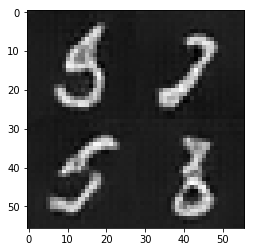

Epoch 1/2... Batch 1510... Discriminator Loss: 1.1198... Generator Loss: 1.0427
Epoch 1/2... Batch 1520... Discriminator Loss: 1.1580... Generator Loss: 0.9868
Epoch 1/2... Batch 1530... Discriminator Loss: 1.1040... Generator Loss: 0.8176
Epoch 1/2... Batch 1540... Discriminator Loss: 1.2119... Generator Loss: 0.6567
Epoch 1/2... Batch 1550... Discriminator Loss: 1.0823... Generator Loss: 0.9761
Epoch 1/2... Batch 1560... Discriminator Loss: 1.1128... Generator Loss: 1.1026
Epoch 1/2... Batch 1570... Discriminator Loss: 1.0954... Generator Loss: 0.8631
Epoch 1/2... Batch 1580... Discriminator Loss: 1.2270... Generator Loss: 0.6492
Epoch 1/2... Batch 1590... Discriminator Loss: 1.1415... Generator Loss: 0.7997
Epoch 1/2... Batch 1600... Discriminator Loss: 1.1126... Generator Loss: 0.7610


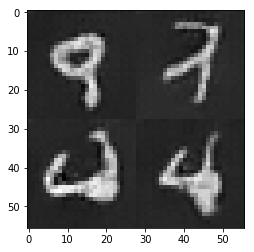

Epoch 1/2... Batch 1610... Discriminator Loss: 1.3809... Generator Loss: 0.4135
Epoch 1/2... Batch 1620... Discriminator Loss: 1.0857... Generator Loss: 0.9166
Epoch 1/2... Batch 1630... Discriminator Loss: 1.0654... Generator Loss: 0.9588
Epoch 1/2... Batch 1640... Discriminator Loss: 1.4978... Generator Loss: 0.3438
Epoch 1/2... Batch 1650... Discriminator Loss: 1.2272... Generator Loss: 0.5643
Epoch 1/2... Batch 1660... Discriminator Loss: 1.1139... Generator Loss: 0.9218
Epoch 1/2... Batch 1670... Discriminator Loss: 1.1959... Generator Loss: 0.7766
Epoch 1/2... Batch 1680... Discriminator Loss: 1.1692... Generator Loss: 1.1793
Epoch 1/2... Batch 1690... Discriminator Loss: 1.2285... Generator Loss: 0.7413
Epoch 1/2... Batch 1700... Discriminator Loss: 1.1175... Generator Loss: 1.0523


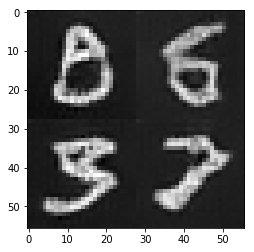

Epoch 1/2... Batch 1710... Discriminator Loss: 1.0782... Generator Loss: 0.9815
Epoch 1/2... Batch 1720... Discriminator Loss: 1.1694... Generator Loss: 0.6522
Epoch 1/2... Batch 1730... Discriminator Loss: 1.0492... Generator Loss: 0.7925
Epoch 1/2... Batch 1740... Discriminator Loss: 1.1305... Generator Loss: 0.7285
Epoch 1/2... Batch 1750... Discriminator Loss: 1.1164... Generator Loss: 0.8932
Epoch 1/2... Batch 1760... Discriminator Loss: 1.1501... Generator Loss: 1.0229
Epoch 1/2... Batch 1770... Discriminator Loss: 1.1437... Generator Loss: 1.1836
Epoch 1/2... Batch 1780... Discriminator Loss: 1.2258... Generator Loss: 0.9554
Epoch 1/2... Batch 1790... Discriminator Loss: 1.1422... Generator Loss: 0.8677
Epoch 1/2... Batch 1800... Discriminator Loss: 1.1237... Generator Loss: 1.1304


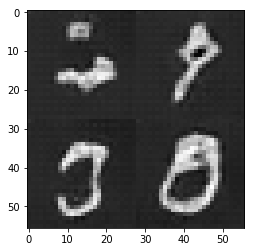

Epoch 1/2... Batch 1810... Discriminator Loss: 1.1303... Generator Loss: 0.7865
Epoch 1/2... Batch 1820... Discriminator Loss: 1.3240... Generator Loss: 1.1287
Epoch 1/2... Batch 1830... Discriminator Loss: 1.2138... Generator Loss: 0.9638
Epoch 1/2... Batch 1840... Discriminator Loss: 1.2037... Generator Loss: 1.3213
Epoch 1/2... Batch 1850... Discriminator Loss: 1.1433... Generator Loss: 0.6783
Epoch 1/2... Batch 1860... Discriminator Loss: 1.1792... Generator Loss: 0.6560
Epoch 1/2... Batch 1870... Discriminator Loss: 1.2515... Generator Loss: 1.1022
Epoch 2/2... Batch 5... Discriminator Loss: 1.1456... Generator Loss: 0.8312
Epoch 2/2... Batch 15... Discriminator Loss: 1.1223... Generator Loss: 0.7217
Epoch 2/2... Batch 25... Discriminator Loss: 1.1603... Generator Loss: 0.7952


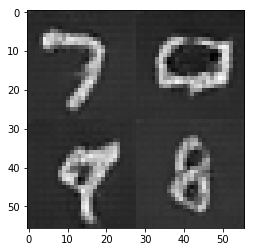

Epoch 2/2... Batch 35... Discriminator Loss: 1.1458... Generator Loss: 0.6738
Epoch 2/2... Batch 45... Discriminator Loss: 1.1266... Generator Loss: 0.9579
Epoch 2/2... Batch 55... Discriminator Loss: 1.0866... Generator Loss: 1.0343
Epoch 2/2... Batch 65... Discriminator Loss: 1.0029... Generator Loss: 1.2945
Epoch 2/2... Batch 75... Discriminator Loss: 1.1108... Generator Loss: 1.0127
Epoch 2/2... Batch 85... Discriminator Loss: 1.0768... Generator Loss: 1.0182
Epoch 2/2... Batch 95... Discriminator Loss: 1.3035... Generator Loss: 0.8357
Epoch 2/2... Batch 105... Discriminator Loss: 1.1972... Generator Loss: 0.6017
Epoch 2/2... Batch 115... Discriminator Loss: 1.1534... Generator Loss: 0.7719
Epoch 2/2... Batch 125... Discriminator Loss: 1.2495... Generator Loss: 0.6170


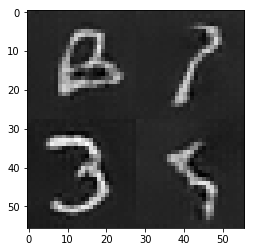

Epoch 2/2... Batch 135... Discriminator Loss: 1.1488... Generator Loss: 0.7870
Epoch 2/2... Batch 145... Discriminator Loss: 1.0069... Generator Loss: 1.2282
Epoch 2/2... Batch 155... Discriminator Loss: 1.0904... Generator Loss: 1.3863
Epoch 2/2... Batch 165... Discriminator Loss: 1.1675... Generator Loss: 1.2065
Epoch 2/2... Batch 175... Discriminator Loss: 1.3098... Generator Loss: 0.5269
Epoch 2/2... Batch 185... Discriminator Loss: 1.1760... Generator Loss: 0.7609
Epoch 2/2... Batch 195... Discriminator Loss: 0.9901... Generator Loss: 0.8653
Epoch 2/2... Batch 205... Discriminator Loss: 1.2004... Generator Loss: 0.8271
Epoch 2/2... Batch 215... Discriminator Loss: 1.1805... Generator Loss: 0.6434
Epoch 2/2... Batch 225... Discriminator Loss: 1.3199... Generator Loss: 0.5109


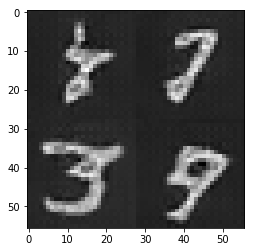

Epoch 2/2... Batch 235... Discriminator Loss: 1.0899... Generator Loss: 1.4337
Epoch 2/2... Batch 245... Discriminator Loss: 1.1785... Generator Loss: 0.6494
Epoch 2/2... Batch 255... Discriminator Loss: 1.1595... Generator Loss: 1.0225
Epoch 2/2... Batch 265... Discriminator Loss: 1.1507... Generator Loss: 0.8838
Epoch 2/2... Batch 275... Discriminator Loss: 1.1644... Generator Loss: 1.0923
Epoch 2/2... Batch 285... Discriminator Loss: 1.2607... Generator Loss: 1.0329
Epoch 2/2... Batch 295... Discriminator Loss: 1.2182... Generator Loss: 0.7439
Epoch 2/2... Batch 305... Discriminator Loss: 1.2418... Generator Loss: 0.5504
Epoch 2/2... Batch 315... Discriminator Loss: 1.1260... Generator Loss: 0.9297
Epoch 2/2... Batch 325... Discriminator Loss: 1.0775... Generator Loss: 0.9677


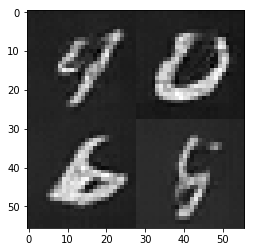

Epoch 2/2... Batch 335... Discriminator Loss: 1.0273... Generator Loss: 1.2503
Epoch 2/2... Batch 345... Discriminator Loss: 1.2419... Generator Loss: 0.5949
Epoch 2/2... Batch 355... Discriminator Loss: 1.1437... Generator Loss: 0.8628
Epoch 2/2... Batch 365... Discriminator Loss: 1.1619... Generator Loss: 0.6234
Epoch 2/2... Batch 375... Discriminator Loss: 1.1861... Generator Loss: 0.9949
Epoch 2/2... Batch 385... Discriminator Loss: 1.1991... Generator Loss: 0.6796
Epoch 2/2... Batch 395... Discriminator Loss: 1.1798... Generator Loss: 0.9179
Epoch 2/2... Batch 405... Discriminator Loss: 1.1878... Generator Loss: 1.1385
Epoch 2/2... Batch 415... Discriminator Loss: 1.1993... Generator Loss: 0.7574
Epoch 2/2... Batch 425... Discriminator Loss: 1.2248... Generator Loss: 0.9780


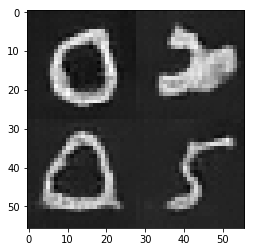

Epoch 2/2... Batch 435... Discriminator Loss: 1.1921... Generator Loss: 0.6520
Epoch 2/2... Batch 445... Discriminator Loss: 1.1552... Generator Loss: 0.7150
Epoch 2/2... Batch 455... Discriminator Loss: 1.2044... Generator Loss: 0.9202
Epoch 2/2... Batch 465... Discriminator Loss: 1.2973... Generator Loss: 1.0088
Epoch 2/2... Batch 475... Discriminator Loss: 1.1284... Generator Loss: 0.8512
Epoch 2/2... Batch 485... Discriminator Loss: 1.2750... Generator Loss: 0.6246
Epoch 2/2... Batch 495... Discriminator Loss: 1.1440... Generator Loss: 1.0011
Epoch 2/2... Batch 505... Discriminator Loss: 1.1751... Generator Loss: 0.6275
Epoch 2/2... Batch 515... Discriminator Loss: 1.1985... Generator Loss: 0.6962
Epoch 2/2... Batch 525... Discriminator Loss: 1.1335... Generator Loss: 0.7375


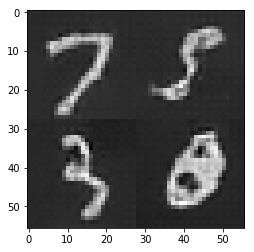

Epoch 2/2... Batch 535... Discriminator Loss: 1.3044... Generator Loss: 0.5226
Epoch 2/2... Batch 545... Discriminator Loss: 1.1097... Generator Loss: 1.1992
Epoch 2/2... Batch 555... Discriminator Loss: 1.1258... Generator Loss: 0.7865
Epoch 2/2... Batch 565... Discriminator Loss: 1.3025... Generator Loss: 0.5777
Epoch 2/2... Batch 575... Discriminator Loss: 1.2771... Generator Loss: 0.6603
Epoch 2/2... Batch 585... Discriminator Loss: 1.3320... Generator Loss: 0.5169
Epoch 2/2... Batch 595... Discriminator Loss: 1.1166... Generator Loss: 1.0290
Epoch 2/2... Batch 605... Discriminator Loss: 1.0861... Generator Loss: 1.0065
Epoch 2/2... Batch 615... Discriminator Loss: 1.1598... Generator Loss: 0.7614
Epoch 2/2... Batch 625... Discriminator Loss: 1.0986... Generator Loss: 0.7342


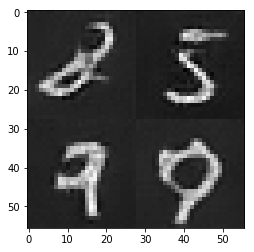

Epoch 2/2... Batch 635... Discriminator Loss: 1.2794... Generator Loss: 0.5774
Epoch 2/2... Batch 645... Discriminator Loss: 1.1584... Generator Loss: 0.6538
Epoch 2/2... Batch 655... Discriminator Loss: 1.1069... Generator Loss: 0.9257
Epoch 2/2... Batch 665... Discriminator Loss: 1.2172... Generator Loss: 0.8958
Epoch 2/2... Batch 675... Discriminator Loss: 1.1274... Generator Loss: 1.0728
Epoch 2/2... Batch 685... Discriminator Loss: 1.1156... Generator Loss: 0.8499
Epoch 2/2... Batch 695... Discriminator Loss: 1.1680... Generator Loss: 1.1393
Epoch 2/2... Batch 705... Discriminator Loss: 1.3462... Generator Loss: 0.4556
Epoch 2/2... Batch 715... Discriminator Loss: 1.1241... Generator Loss: 0.7843
Epoch 2/2... Batch 725... Discriminator Loss: 1.0888... Generator Loss: 0.9594


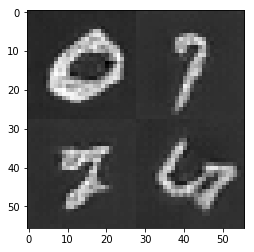

Epoch 2/2... Batch 735... Discriminator Loss: 1.1498... Generator Loss: 0.6163
Epoch 2/2... Batch 745... Discriminator Loss: 1.1040... Generator Loss: 0.7706
Epoch 2/2... Batch 755... Discriminator Loss: 1.0714... Generator Loss: 1.0159
Epoch 2/2... Batch 765... Discriminator Loss: 1.1631... Generator Loss: 0.9498
Epoch 2/2... Batch 775... Discriminator Loss: 1.2489... Generator Loss: 0.6730
Epoch 2/2... Batch 785... Discriminator Loss: 1.1653... Generator Loss: 0.6884
Epoch 2/2... Batch 795... Discriminator Loss: 1.1533... Generator Loss: 0.7546
Epoch 2/2... Batch 805... Discriminator Loss: 1.3673... Generator Loss: 1.1489
Epoch 2/2... Batch 815... Discriminator Loss: 1.1779... Generator Loss: 1.1558
Epoch 2/2... Batch 825... Discriminator Loss: 1.0317... Generator Loss: 0.9363


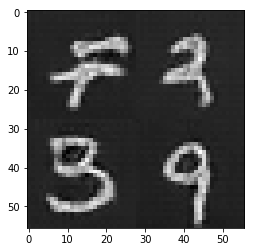

Epoch 2/2... Batch 835... Discriminator Loss: 1.2439... Generator Loss: 1.0811
Epoch 2/2... Batch 845... Discriminator Loss: 1.2339... Generator Loss: 0.7217
Epoch 2/2... Batch 855... Discriminator Loss: 1.3374... Generator Loss: 1.2162
Epoch 2/2... Batch 865... Discriminator Loss: 1.1674... Generator Loss: 0.6045
Epoch 2/2... Batch 875... Discriminator Loss: 1.1613... Generator Loss: 0.9910
Epoch 2/2... Batch 885... Discriminator Loss: 1.3241... Generator Loss: 1.3701
Epoch 2/2... Batch 895... Discriminator Loss: 1.2484... Generator Loss: 0.7275
Epoch 2/2... Batch 905... Discriminator Loss: 1.1611... Generator Loss: 0.9502
Epoch 2/2... Batch 915... Discriminator Loss: 1.2197... Generator Loss: 0.6503
Epoch 2/2... Batch 925... Discriminator Loss: 1.1431... Generator Loss: 0.9631


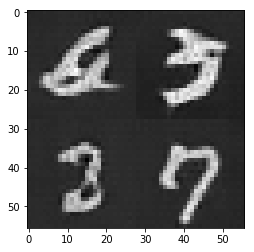

Epoch 2/2... Batch 935... Discriminator Loss: 1.2167... Generator Loss: 0.7678
Epoch 2/2... Batch 945... Discriminator Loss: 1.0186... Generator Loss: 1.1464
Epoch 2/2... Batch 955... Discriminator Loss: 1.1648... Generator Loss: 1.1506
Epoch 2/2... Batch 965... Discriminator Loss: 1.0906... Generator Loss: 0.9114
Epoch 2/2... Batch 975... Discriminator Loss: 1.1450... Generator Loss: 1.2594
Epoch 2/2... Batch 985... Discriminator Loss: 1.1126... Generator Loss: 0.7803
Epoch 2/2... Batch 995... Discriminator Loss: 1.2836... Generator Loss: 0.5915
Epoch 2/2... Batch 1005... Discriminator Loss: 1.1762... Generator Loss: 0.6626
Epoch 2/2... Batch 1015... Discriminator Loss: 1.1070... Generator Loss: 0.9050
Epoch 2/2... Batch 1025... Discriminator Loss: 1.3769... Generator Loss: 0.4731


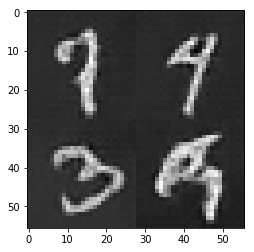

Epoch 2/2... Batch 1035... Discriminator Loss: 1.1932... Generator Loss: 0.6366
Epoch 2/2... Batch 1045... Discriminator Loss: 1.2207... Generator Loss: 1.1318
Epoch 2/2... Batch 1055... Discriminator Loss: 1.2176... Generator Loss: 0.6843
Epoch 2/2... Batch 1065... Discriminator Loss: 1.3266... Generator Loss: 0.4663
Epoch 2/2... Batch 1075... Discriminator Loss: 1.1044... Generator Loss: 0.8218
Epoch 2/2... Batch 1085... Discriminator Loss: 1.2971... Generator Loss: 0.7277
Epoch 2/2... Batch 1095... Discriminator Loss: 1.2269... Generator Loss: 1.0330
Epoch 2/2... Batch 1105... Discriminator Loss: 1.2119... Generator Loss: 0.7059
Epoch 2/2... Batch 1115... Discriminator Loss: 1.1930... Generator Loss: 0.7369
Epoch 2/2... Batch 1125... Discriminator Loss: 1.1945... Generator Loss: 1.0811


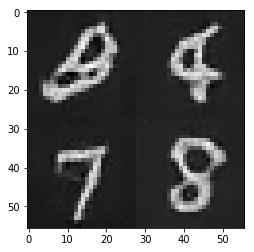

Epoch 2/2... Batch 1135... Discriminator Loss: 1.0939... Generator Loss: 0.9041
Epoch 2/2... Batch 1145... Discriminator Loss: 1.2647... Generator Loss: 0.6126
Epoch 2/2... Batch 1155... Discriminator Loss: 1.2235... Generator Loss: 1.1419
Epoch 2/2... Batch 1165... Discriminator Loss: 1.2242... Generator Loss: 0.7987
Epoch 2/2... Batch 1175... Discriminator Loss: 1.1686... Generator Loss: 0.7536
Epoch 2/2... Batch 1185... Discriminator Loss: 1.0881... Generator Loss: 1.0317
Epoch 2/2... Batch 1195... Discriminator Loss: 1.0454... Generator Loss: 1.0437
Epoch 2/2... Batch 1205... Discriminator Loss: 1.1055... Generator Loss: 1.0240
Epoch 2/2... Batch 1215... Discriminator Loss: 1.1272... Generator Loss: 0.8361
Epoch 2/2... Batch 1225... Discriminator Loss: 1.2112... Generator Loss: 1.1695


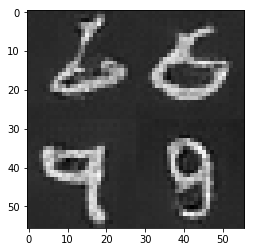

Epoch 2/2... Batch 1235... Discriminator Loss: 1.1537... Generator Loss: 0.8506
Epoch 2/2... Batch 1245... Discriminator Loss: 1.2592... Generator Loss: 0.5509
Epoch 2/2... Batch 1255... Discriminator Loss: 1.1378... Generator Loss: 0.7681
Epoch 2/2... Batch 1265... Discriminator Loss: 1.1319... Generator Loss: 1.2610
Epoch 2/2... Batch 1275... Discriminator Loss: 1.1887... Generator Loss: 0.6204
Epoch 2/2... Batch 1285... Discriminator Loss: 1.0662... Generator Loss: 1.2275
Epoch 2/2... Batch 1295... Discriminator Loss: 1.1074... Generator Loss: 0.8108
Epoch 2/2... Batch 1305... Discriminator Loss: 1.1316... Generator Loss: 0.9097
Epoch 2/2... Batch 1315... Discriminator Loss: 1.1508... Generator Loss: 0.6695
Epoch 2/2... Batch 1325... Discriminator Loss: 1.2808... Generator Loss: 0.5710


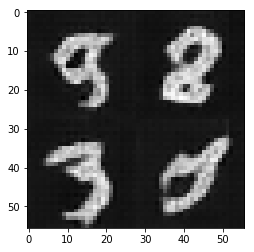

Epoch 2/2... Batch 1335... Discriminator Loss: 1.1782... Generator Loss: 1.0946
Epoch 2/2... Batch 1345... Discriminator Loss: 1.1962... Generator Loss: 0.8135
Epoch 2/2... Batch 1355... Discriminator Loss: 1.0307... Generator Loss: 0.9535
Epoch 2/2... Batch 1365... Discriminator Loss: 1.1746... Generator Loss: 0.8161
Epoch 2/2... Batch 1375... Discriminator Loss: 1.0505... Generator Loss: 1.2498
Epoch 2/2... Batch 1385... Discriminator Loss: 1.1562... Generator Loss: 1.0405
Epoch 2/2... Batch 1395... Discriminator Loss: 1.0611... Generator Loss: 0.8067
Epoch 2/2... Batch 1405... Discriminator Loss: 1.1805... Generator Loss: 0.7516
Epoch 2/2... Batch 1415... Discriminator Loss: 1.2665... Generator Loss: 1.0118
Epoch 2/2... Batch 1425... Discriminator Loss: 1.1838... Generator Loss: 1.0080


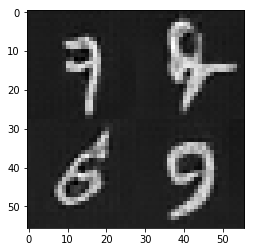

Epoch 2/2... Batch 1435... Discriminator Loss: 1.3737... Generator Loss: 0.5148
Epoch 2/2... Batch 1445... Discriminator Loss: 1.1309... Generator Loss: 1.2482
Epoch 2/2... Batch 1455... Discriminator Loss: 1.2974... Generator Loss: 0.6538
Epoch 2/2... Batch 1465... Discriminator Loss: 1.1349... Generator Loss: 1.1576
Epoch 2/2... Batch 1475... Discriminator Loss: 1.0745... Generator Loss: 0.9978
Epoch 2/2... Batch 1485... Discriminator Loss: 1.3587... Generator Loss: 0.4567
Epoch 2/2... Batch 1495... Discriminator Loss: 1.0785... Generator Loss: 0.9558
Epoch 2/2... Batch 1505... Discriminator Loss: 1.1473... Generator Loss: 0.9047
Epoch 2/2... Batch 1515... Discriminator Loss: 1.0096... Generator Loss: 1.1397
Epoch 2/2... Batch 1525... Discriminator Loss: 1.0399... Generator Loss: 0.7852


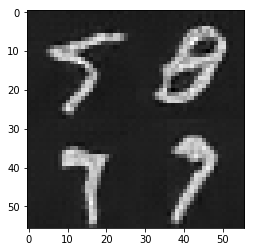

Epoch 2/2... Batch 1535... Discriminator Loss: 1.2169... Generator Loss: 0.6659
Epoch 2/2... Batch 1545... Discriminator Loss: 1.1100... Generator Loss: 1.3515
Epoch 2/2... Batch 1555... Discriminator Loss: 1.0375... Generator Loss: 0.9623
Epoch 2/2... Batch 1565... Discriminator Loss: 1.0581... Generator Loss: 0.9089
Epoch 2/2... Batch 1575... Discriminator Loss: 1.1875... Generator Loss: 0.8472
Epoch 2/2... Batch 1585... Discriminator Loss: 1.0822... Generator Loss: 0.7383
Epoch 2/2... Batch 1595... Discriminator Loss: 1.2070... Generator Loss: 0.6459
Epoch 2/2... Batch 1605... Discriminator Loss: 1.1894... Generator Loss: 0.6800
Epoch 2/2... Batch 1615... Discriminator Loss: 0.9474... Generator Loss: 1.3876
Epoch 2/2... Batch 1625... Discriminator Loss: 1.1751... Generator Loss: 0.7940


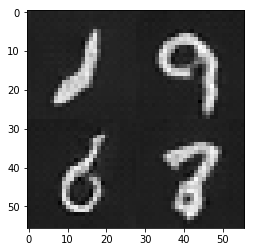

Epoch 2/2... Batch 1635... Discriminator Loss: 1.0702... Generator Loss: 1.1290
Epoch 2/2... Batch 1645... Discriminator Loss: 1.1385... Generator Loss: 0.7394
Epoch 2/2... Batch 1655... Discriminator Loss: 1.3137... Generator Loss: 0.5269
Epoch 2/2... Batch 1665... Discriminator Loss: 1.0961... Generator Loss: 0.8594
Epoch 2/2... Batch 1675... Discriminator Loss: 1.2417... Generator Loss: 1.1421
Epoch 2/2... Batch 1685... Discriminator Loss: 1.0912... Generator Loss: 1.0733
Epoch 2/2... Batch 1695... Discriminator Loss: 1.1811... Generator Loss: 0.9048
Epoch 2/2... Batch 1705... Discriminator Loss: 1.1579... Generator Loss: 0.9133
Epoch 2/2... Batch 1715... Discriminator Loss: 1.1204... Generator Loss: 0.9701
Epoch 2/2... Batch 1725... Discriminator Loss: 1.0657... Generator Loss: 1.2142


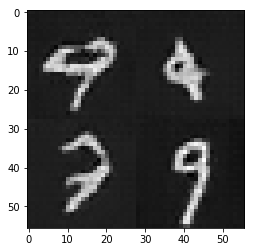

Epoch 2/2... Batch 1735... Discriminator Loss: 1.1021... Generator Loss: 0.8278
Epoch 2/2... Batch 1745... Discriminator Loss: 1.0194... Generator Loss: 0.9915
Epoch 2/2... Batch 1755... Discriminator Loss: 1.2030... Generator Loss: 0.8148
Epoch 2/2... Batch 1765... Discriminator Loss: 1.2377... Generator Loss: 0.8257
Epoch 2/2... Batch 1775... Discriminator Loss: 1.0562... Generator Loss: 0.9931
Epoch 2/2... Batch 1785... Discriminator Loss: 1.2615... Generator Loss: 0.8649
Epoch 2/2... Batch 1795... Discriminator Loss: 1.0441... Generator Loss: 0.9686
Epoch 2/2... Batch 1805... Discriminator Loss: 1.3487... Generator Loss: 0.4891
Epoch 2/2... Batch 1815... Discriminator Loss: 1.0375... Generator Loss: 1.3542
Epoch 2/2... Batch 1825... Discriminator Loss: 1.0881... Generator Loss: 0.9379


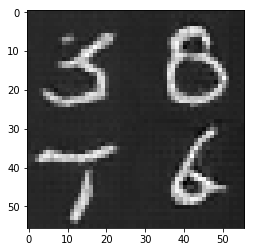

Epoch 2/2... Batch 1835... Discriminator Loss: 1.0974... Generator Loss: 0.7810
Epoch 2/2... Batch 1845... Discriminator Loss: 1.2042... Generator Loss: 0.8086
Epoch 2/2... Batch 1855... Discriminator Loss: 1.1469... Generator Loss: 0.7002
Epoch 2/2... Batch 1865... Discriminator Loss: 1.2333... Generator Loss: 0.7871
Epoch 2/2... Batch 1875... Discriminator Loss: 1.2390... Generator Loss: 1.1012


In [12]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Batch 10... Discriminator Loss: 0.8926... Generator Loss: 0.7510
Epoch 1/1... Batch 20... Discriminator Loss: 1.1106... Generator Loss: 0.4560
Epoch 1/1... Batch 30... Discriminator Loss: 0.7544... Generator Loss: 0.6502
Epoch 1/1... Batch 40... Discriminator Loss: 0.7991... Generator Loss: 0.6381
Epoch 1/1... Batch 50... Discriminator Loss: 0.5294... Generator Loss: 0.9450
Epoch 1/1... Batch 60... Discriminator Loss: 0.2951... Generator Loss: 1.7757
Epoch 1/1... Batch 70... Discriminator Loss: 0.3786... Generator Loss: 1.9444
Epoch 1/1... Batch 80... Discriminator Loss: 0.5774... Generator Loss: 1.6102
Epoch 1/1... Batch 90... Discriminator Loss: 0.4023... Generator Loss: 1.3109
Epoch 1/1... Batch 100... Discriminator Loss: 1.1527... Generator Loss: 1.5458


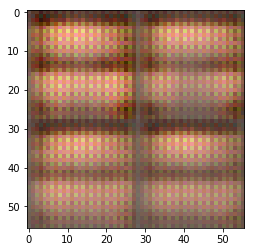

Epoch 1/1... Batch 110... Discriminator Loss: 0.9637... Generator Loss: 1.1979
Epoch 1/1... Batch 120... Discriminator Loss: 0.8657... Generator Loss: 1.1350
Epoch 1/1... Batch 130... Discriminator Loss: 0.6305... Generator Loss: 1.3659
Epoch 1/1... Batch 140... Discriminator Loss: 1.1622... Generator Loss: 1.4441
Epoch 1/1... Batch 150... Discriminator Loss: 0.6744... Generator Loss: 1.0344
Epoch 1/1... Batch 160... Discriminator Loss: 0.3527... Generator Loss: 1.5519
Epoch 1/1... Batch 170... Discriminator Loss: 1.1346... Generator Loss: 0.5620
Epoch 1/1... Batch 180... Discriminator Loss: 0.7281... Generator Loss: 1.5329
Epoch 1/1... Batch 190... Discriminator Loss: 0.8299... Generator Loss: 1.3921
Epoch 1/1... Batch 200... Discriminator Loss: 1.7457... Generator Loss: 0.4229


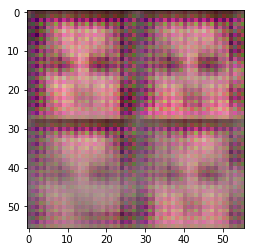

Epoch 1/1... Batch 210... Discriminator Loss: 0.9956... Generator Loss: 1.0363
Epoch 1/1... Batch 220... Discriminator Loss: 0.7880... Generator Loss: 1.0617
Epoch 1/1... Batch 230... Discriminator Loss: 1.1790... Generator Loss: 0.9692
Epoch 1/1... Batch 240... Discriminator Loss: 0.9768... Generator Loss: 0.9118
Epoch 1/1... Batch 250... Discriminator Loss: 1.2152... Generator Loss: 0.8599
Epoch 1/1... Batch 260... Discriminator Loss: 0.7804... Generator Loss: 1.2598
Epoch 1/1... Batch 270... Discriminator Loss: 1.7796... Generator Loss: 0.5350
Epoch 1/1... Batch 280... Discriminator Loss: 1.3009... Generator Loss: 0.6768
Epoch 1/1... Batch 290... Discriminator Loss: 1.0613... Generator Loss: 0.9216
Epoch 1/1... Batch 300... Discriminator Loss: 0.8958... Generator Loss: 0.9407


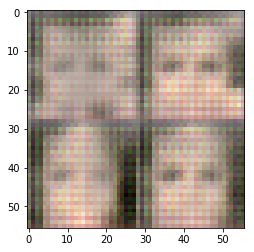

Epoch 1/1... Batch 310... Discriminator Loss: 0.8573... Generator Loss: 1.1019
Epoch 1/1... Batch 320... Discriminator Loss: 0.8841... Generator Loss: 1.1535
Epoch 1/1... Batch 330... Discriminator Loss: 1.2278... Generator Loss: 0.9610
Epoch 1/1... Batch 340... Discriminator Loss: 0.7810... Generator Loss: 1.3015
Epoch 1/1... Batch 350... Discriminator Loss: 1.0912... Generator Loss: 1.1122
Epoch 1/1... Batch 360... Discriminator Loss: 0.9496... Generator Loss: 0.8861
Epoch 1/1... Batch 370... Discriminator Loss: 0.9321... Generator Loss: 1.1982
Epoch 1/1... Batch 380... Discriminator Loss: 1.3327... Generator Loss: 0.9325
Epoch 1/1... Batch 390... Discriminator Loss: 1.2852... Generator Loss: 0.7697
Epoch 1/1... Batch 400... Discriminator Loss: 1.1898... Generator Loss: 0.8227


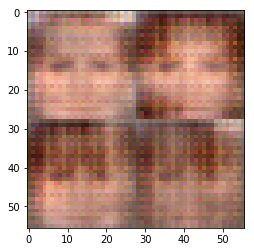

Epoch 1/1... Batch 410... Discriminator Loss: 1.4334... Generator Loss: 0.6760
Epoch 1/1... Batch 420... Discriminator Loss: 1.1848... Generator Loss: 0.8905
Epoch 1/1... Batch 430... Discriminator Loss: 1.4335... Generator Loss: 0.7633
Epoch 1/1... Batch 440... Discriminator Loss: 1.2318... Generator Loss: 0.8411
Epoch 1/1... Batch 450... Discriminator Loss: 1.2023... Generator Loss: 0.8230
Epoch 1/1... Batch 460... Discriminator Loss: 1.4111... Generator Loss: 0.6924
Epoch 1/1... Batch 470... Discriminator Loss: 1.2911... Generator Loss: 0.7665
Epoch 1/1... Batch 480... Discriminator Loss: 1.2710... Generator Loss: 0.8388
Epoch 1/1... Batch 490... Discriminator Loss: 1.3210... Generator Loss: 0.8173
Epoch 1/1... Batch 500... Discriminator Loss: 1.2547... Generator Loss: 0.7676


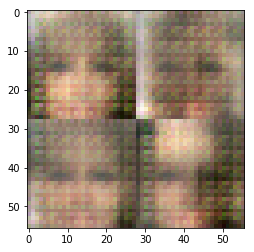

Epoch 1/1... Batch 510... Discriminator Loss: 1.1973... Generator Loss: 0.8066
Epoch 1/1... Batch 520... Discriminator Loss: 1.2237... Generator Loss: 0.8565
Epoch 1/1... Batch 530... Discriminator Loss: 1.4279... Generator Loss: 0.6633
Epoch 1/1... Batch 540... Discriminator Loss: 1.2587... Generator Loss: 0.8163
Epoch 1/1... Batch 550... Discriminator Loss: 1.4307... Generator Loss: 0.7354
Epoch 1/1... Batch 560... Discriminator Loss: 1.2889... Generator Loss: 0.8048
Epoch 1/1... Batch 570... Discriminator Loss: 1.2745... Generator Loss: 0.7445
Epoch 1/1... Batch 580... Discriminator Loss: 1.4088... Generator Loss: 0.7266
Epoch 1/1... Batch 590... Discriminator Loss: 1.3373... Generator Loss: 0.7092
Epoch 1/1... Batch 600... Discriminator Loss: 1.1251... Generator Loss: 0.8224


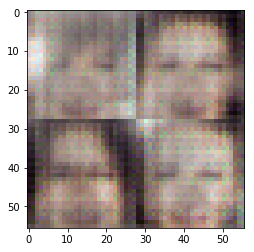

Epoch 1/1... Batch 610... Discriminator Loss: 1.5672... Generator Loss: 0.6549
Epoch 1/1... Batch 620... Discriminator Loss: 1.2347... Generator Loss: 0.8790
Epoch 1/1... Batch 630... Discriminator Loss: 1.4544... Generator Loss: 0.6612
Epoch 1/1... Batch 640... Discriminator Loss: 1.1950... Generator Loss: 0.8922
Epoch 1/1... Batch 660... Discriminator Loss: 1.2698... Generator Loss: 0.7592
Epoch 1/1... Batch 670... Discriminator Loss: 1.2449... Generator Loss: 0.8409
Epoch 1/1... Batch 680... Discriminator Loss: 1.3679... Generator Loss: 0.6619
Epoch 1/1... Batch 690... Discriminator Loss: 1.2859... Generator Loss: 0.7844
Epoch 1/1... Batch 700... Discriminator Loss: 1.3687... Generator Loss: 0.8039


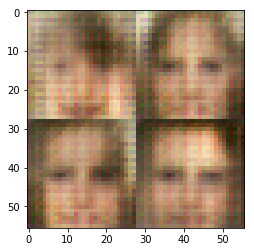

Epoch 1/1... Batch 710... Discriminator Loss: 1.2971... Generator Loss: 0.6747
Epoch 1/1... Batch 720... Discriminator Loss: 1.0549... Generator Loss: 0.7720
Epoch 1/1... Batch 730... Discriminator Loss: 1.5231... Generator Loss: 0.7044
Epoch 1/1... Batch 740... Discriminator Loss: 1.3562... Generator Loss: 0.7169
Epoch 1/1... Batch 750... Discriminator Loss: 1.4296... Generator Loss: 0.6783
Epoch 1/1... Batch 760... Discriminator Loss: 1.3634... Generator Loss: 0.8396
Epoch 1/1... Batch 770... Discriminator Loss: 1.3875... Generator Loss: 0.6844
Epoch 1/1... Batch 780... Discriminator Loss: 1.2256... Generator Loss: 0.7529
Epoch 1/1... Batch 790... Discriminator Loss: 1.4946... Generator Loss: 0.6800


In [ ]:
batch_size = 256
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.